Epoch 1/20 — loss: 2.0622
Epoch 2/20 — loss: 1.6189
Epoch 3/20 — loss: 1.3931
Epoch 4/20 — loss: 1.1369
Epoch 5/20 — loss: 0.8406
Epoch 6/20 — loss: 0.6784
Epoch 7/20 — loss: 0.4698
Epoch 8/20 — loss: 0.3331
Epoch 9/20 — loss: 0.2653
Epoch 10/20 — loss: 0.1890
Epoch 11/20 — loss: 0.1264
Epoch 12/20 — loss: 0.0844
Epoch 13/20 — loss: 0.0621
Epoch 14/20 — loss: 0.0282
Epoch 15/20 — loss: 0.0205
Epoch 16/20 — loss: 0.0123
Epoch 17/20 — loss: 0.0097
Epoch 18/20 — loss: 0.0081
Epoch 19/20 — loss: 0.0071
Epoch 20/20 — loss: 0.0073
Test Accuracy: 0.8969
Precision (macro): 0.9067
Recall    (macro): 0.8726
F1-score  (macro): 0.8848


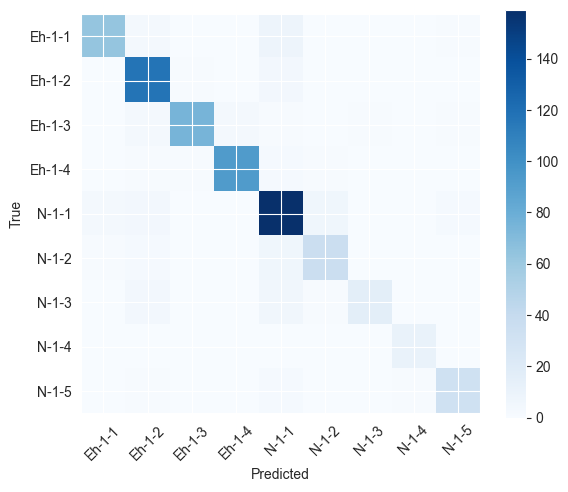

In [9]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../raw'                   # image data path
text_data_path = 'Sample Data Texts.xlsx'   # text-data Excel
image_size     = (32, 32)
batch_size     = 32
num_epochs     = 20
lr_img         = 1e-3
lr_text        = 5e-5
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + GPT-2 fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

# Initialize GPT-2 tokenizer & model
tokenizer   = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
text_model  = GPT2Model.from_pretrained("gpt2").to(device)

# Freeze all layers
for p in text_model.parameters():
    p.requires_grad = False
# Unfreeze the last two transformer blocks
for name, p in text_model.named_parameters():
    if "h.10" in name or "h.11" in name:
        p.requires_grad = True
text_model.train()

# Pre-compute a fixed text vector (using last token hidden state)
with torch.no_grad():
    txt_inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    outputs = text_model(**txt_inputs)
    txt_vec = outputs.last_hidden_state[:, -1, :].squeeze(0).to(device)  # (hidden,)

# -----------------------------
# 3. Define the ResNet + text-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionText(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, text_dim=768):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        def mk(planes, cnt, stride):
            seq = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, cnt):
                seq.append(block(self.in_planes, planes))
            return nn.Sequential(*seq)
        self.layer1 = mk(64,  layers[0], 1)
        self.layer2 = mk(128, layers[1], 2)
        self.layer3 = mk(256, layers[2], 2)
        self.layer4 = mk(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))
        self.w_img  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text = nn.Parameter(torch.tensor(1.0, device=device))
        self.fc     = nn.Linear(512 + text_dim, num_classes)
    def forward(self, x, text_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)
        B = x.size(0)
        img_f = x * self.w_img
        # text_vec: (hidden,), expand to (B, hidden)
        txt_f = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        return self.fc(torch.cat([img_f, txt_f], dim=1))

def build_model(n_cls):
    return ResNetFusionText(BasicBlock, [2, 2, 2, 2], n_cls).to(device)

model = build_model(num_classes)

# -----------------------------
# 4. Optimizer & LR scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                         'lr': lr_img},
    {'params': text_model.h[10].parameters(),              'lr': lr_text},
    {'params': text_model.h[11].parameters(),              'lr': lr_text},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 5. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    text_model.train()
    total_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        # reuse pre-computed txt_vec of shape (hidden,)
        optimizer.zero_grad()
        loss = criterion(model(imgs, txt_vec), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

# -----------------------------
# 6. Evaluation
# -----------------------------
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs, txt_vec).argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

# Metrics
accuracy = (np.array(all_pred) == np.array(all_true)).mean()
precision = precision_score(all_true, all_pred, average='macro')
recall    = recall_score(all_true, all_pred, average='macro')
f1        = f1_score(all_true, all_pred, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(num_classes), le.classes_, rotation=45)
plt.yticks(range(num_classes), le.classes_)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Epoch 1/20 — loss: 2.0462
Epoch 2/20 — loss: 1.7034
Epoch 3/20 — loss: 1.3779
Epoch 4/20 — loss: 1.0945
Epoch 5/20 — loss: 0.8172
Epoch 6/20 — loss: 0.5924
Epoch 7/20 — loss: 0.4083
Epoch 8/20 — loss: 0.3583
Epoch 9/20 — loss: 0.2211
Epoch 10/20 — loss: 0.1020
Epoch 11/20 — loss: 0.0791
Epoch 12/20 — loss: 0.0432
Epoch 13/20 — loss: 0.0231
Epoch 14/20 — loss: 0.0170
Epoch 15/20 — loss: 0.0082
Epoch 16/20 — loss: 0.0080
Epoch 17/20 — loss: 0.0048
Epoch 18/20 — loss: 0.0065
Epoch 19/20 — loss: 0.0045
Epoch 20/20 — loss: 0.0049
Test Accuracy: 0.9073
Precision (macro): 0.8989
Recall    (macro): 0.8786
F1-score  (macro): 0.8867


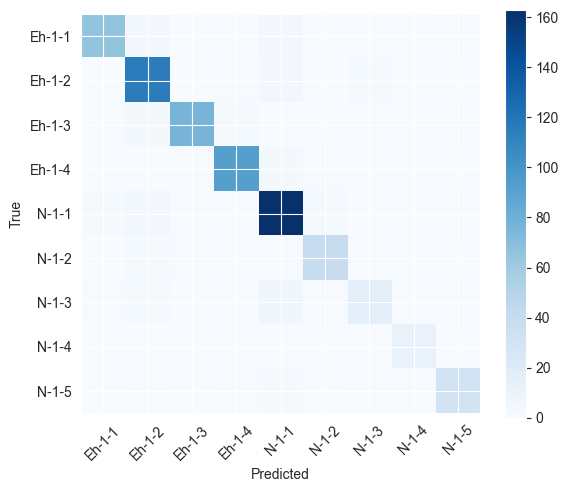

In [8]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../raw'                   # image data path
text_data_path = 'Sample Data Texts.xlsx'   # text-data Excel
image_size     = (32, 32)
batch_size     = 32
num_epochs     = 20
lr_img         = 1e-3
lr_text        = 5e-5
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + GPT-2 Medium fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

# Initialize GPT-2 Medium tokenizer & model
tokenizer   = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer.pad_token = tokenizer.eos_token
text_model  = GPT2Model.from_pretrained("gpt2-medium").to(device)

# Freeze all layers
for p in text_model.parameters():
    p.requires_grad = False

# Unfreeze the last two transformer blocks (layers 22 & 23)
for name, p in text_model.named_parameters():
    if "h.22" in name or "h.23" in name:
        p.requires_grad = True

text_model.train()

# Pre-compute a fixed text vector (use last token hidden state)
with torch.no_grad():
    txt_inputs = tokenizer(combined_text,
                           return_tensors="pt",
                           truncation=True,
                           padding=True)
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    outputs = text_model(**txt_inputs)
    txt_vec = outputs.last_hidden_state[:, -1, :].squeeze(0)  # (1024,)

# -----------------------------
# 3. Define the ResNet + text-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionText(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, text_dim=1024):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        def mk(planes, cnt, stride):
            seq = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, cnt):
                seq.append(block(self.in_planes, planes))
            return nn.Sequential(*seq)
        self.layer1 = mk(64,  layers[0], 1)
        self.layer2 = mk(128, layers[1], 2)
        self.layer3 = mk(256, layers[2], 2)
        self.layer4 = mk(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))
        self.w_img  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text = nn.Parameter(torch.tensor(1.0, device=device))
        self.fc     = nn.Linear(512 + text_dim, num_classes)

    def forward(self, x, text_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)
        B = x.size(0)
        img_f = x * self.w_img
        txt_f = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        return self.fc(torch.cat([img_f, txt_f], dim=1))

def build_model(n_cls):
    return ResNetFusionText(BasicBlock, [2, 2, 2, 2], n_cls, in_ch=1, text_dim=1024).to(device)

model = build_model(num_classes)

# -----------------------------
# 4. Optimizer & LR scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                    'lr': lr_img},
    {'params': text_model.h[22].parameters(),         'lr': lr_text},
    {'params': text_model.h[23].parameters(),         'lr': lr_text},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 5. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    text_model.train()
    total_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs, txt_vec), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

# -----------------------------
# 6. Evaluation
# -----------------------------
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs, txt_vec).argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

accuracy = (np.array(all_pred) == np.array(all_true)).mean()
precision = precision_score(all_true, all_pred, average='macro')
recall    = recall_score(all_true, all_pred, average='macro')
f1        = f1_score(all_true, all_pred, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")



Epoch 1/20 — loss: 1.9242
Epoch 2/20 — loss: 1.6333
Epoch 3/20 — loss: 1.3798
Epoch 4/20 — loss: 1.0535
Epoch 5/20 — loss: 0.8245
Epoch 6/20 — loss: 0.5778
Epoch 7/20 — loss: 0.4407
Epoch 8/20 — loss: 0.3235
Epoch 9/20 — loss: 0.2426
Epoch 10/20 — loss: 0.1412
Epoch 11/20 — loss: 0.1097
Epoch 12/20 — loss: 0.0591
Epoch 13/20 — loss: 0.0334
Epoch 14/20 — loss: 0.0223
Epoch 15/20 — loss: 0.0179
Epoch 16/20 — loss: 0.0117
Epoch 17/20 — loss: 0.0087
Epoch 18/20 — loss: 0.0087
Epoch 19/20 — loss: 0.0067
Epoch 20/20 — loss: 0.0052
Test Accuracy: 0.9013
Precision (macro): 0.8957
Recall    (macro): 0.8667
F1-score  (macro): 0.8775


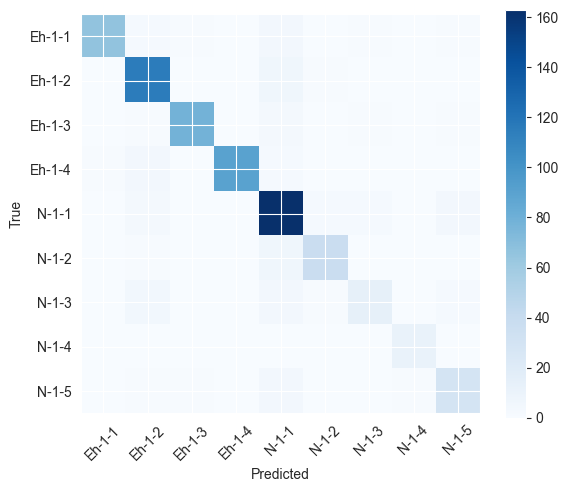

In [13]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../raw'                   # image data path
text_data_path = 'Sample Data Texts.xlsx'   # text-data Excel
image_size     = (32, 32)
batch_size     = 32
num_epochs     = 20
lr_img         = 1e-3
lr_text        = 5e-5
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + GPT-2 Large fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

# Initialize GPT-2 Large tokenizer & model
tokenizer   = GPT2Tokenizer.from_pretrained("gpt2-large")
tokenizer.pad_token = tokenizer.eos_token
text_model  = GPT2Model.from_pretrained("gpt2-large").to(device)

# Freeze all layers
for p in text_model.parameters():
    p.requires_grad = False

# Unfreeze the last two transformer blocks (layers 34 & 35)
for name, p in text_model.named_parameters():
    if "h.34" in name or "h.35" in name:
        p.requires_grad = True

text_model.train()

# Pre-compute a fixed text vector (use last token hidden state)
with torch.no_grad():
    txt_inputs = tokenizer(
        combined_text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    outputs = text_model(**txt_inputs)
    txt_vec = outputs.last_hidden_state[:, -1, :].squeeze(0)  # (1280,)

# -----------------------------
# 3. Define the ResNet + text-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionText(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, text_dim=1280):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        def mk(planes, cnt, stride):
            seq = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, cnt):
                seq.append(block(self.in_planes, planes))
            return nn.Sequential(*seq)
        self.layer1 = mk(64,  layers[0], 1)
        self.layer2 = mk(128, layers[1], 2)
        self.layer3 = mk(256, layers[2], 2)
        self.layer4 = mk(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))
        self.w_img  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text = nn.Parameter(torch.tensor(1.0, device=device))
        self.fc     = nn.Linear(512 + text_dim, num_classes)

    def forward(self, x, text_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)
        B = x.size(0)
        img_f = x * self.w_img
        txt_f = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        return self.fc(torch.cat([img_f, txt_f], dim=1))

def build_model(n_cls):
    return ResNetFusionText(BasicBlock, [2, 2, 2, 2], n_cls, in_ch=1, text_dim=1280).to(device)

model = build_model(num_classes)

# -----------------------------
# 4. Optimizer & LR scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                   'lr': lr_img},
    {'params': text_model.h[34].parameters(),        'lr': lr_text},
    {'params': text_model.h[35].parameters(),        'lr': lr_text},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 5. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    text_model.train()
    total_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs, txt_vec), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

# -----------------------------
# 6. Evaluation
# -----------------------------
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs, txt_vec).argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

accuracy = (np.array(all_pred) == np.array(all_true)).mean()
precision = precision_score(all_true, all_pred, average='macro')
recall    = recall_score(all_true, all_pred, average='macro')
f1        = f1_score(all_true, all_pred, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")



Epoch 1/20 — loss: 1.8668
Epoch 2/20 — loss: 1.5415
Epoch 3/20 — loss: 1.2053
Epoch 4/20 — loss: 0.9630
Epoch 5/20 — loss: 0.7621
Epoch 6/20 — loss: 0.5785
Epoch 7/20 — loss: 0.3684
Epoch 8/20 — loss: 0.2667
Epoch 9/20 — loss: 0.1920
Epoch 10/20 — loss: 0.1560
Epoch 11/20 — loss: 0.0945
Epoch 12/20 — loss: 0.0436
Epoch 13/20 — loss: 0.0325
Epoch 14/20 — loss: 0.0173
Epoch 15/20 — loss: 0.0134
Epoch 16/20 — loss: 0.0102
Epoch 17/20 — loss: 0.0097
Epoch 18/20 — loss: 0.0047
Epoch 19/20 — loss: 0.0053
Epoch 20/20 — loss: 0.0043
Test Accuracy: 0.9028
Precision (macro): 0.8905
Recall    (macro): 0.8763
F1-score  (macro): 0.8819


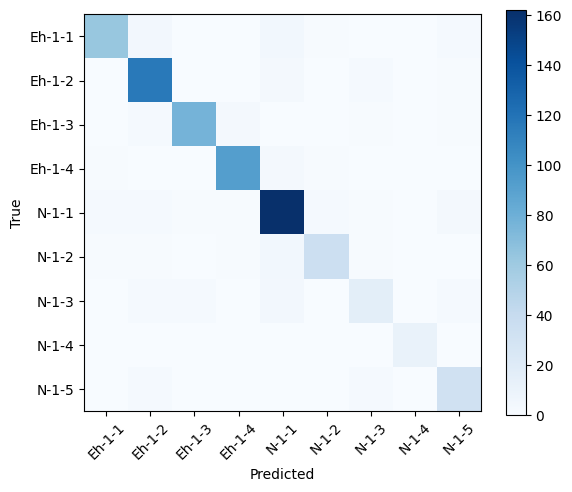

In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../raw'                   # image data path
text_data_path = 'Sample Data Texts.xlsx'   # text-data Excel
image_size     = (32, 32)
batch_size     = 32
num_epochs     = 20
lr_img         = 1e-3
lr_text        = 5e-5
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + GPT-2 XL fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

# Initialize GPT-2 XL tokenizer & model
tokenizer   = GPT2Tokenizer.from_pretrained("gpt2-xl")
tokenizer.pad_token = tokenizer.eos_token
text_model  = GPT2Model.from_pretrained("gpt2-xl").to(device)

# Freeze all layers
for p in text_model.parameters():
    p.requires_grad = False

# Unfreeze the last two transformer blocks (layers 46 & 47)
for name, p in text_model.named_parameters():
    if "h.46" in name or "h.47" in name:
        p.requires_grad = True

text_model.train()

# Pre-compute a fixed text vector (use last token hidden state)
with torch.no_grad():
    txt_inputs = tokenizer(
        combined_text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    outputs = text_model(**txt_inputs)
    txt_vec = outputs.last_hidden_state[:, -1, :].squeeze(0)  # (1600,)

# -----------------------------
# 3. Define the ResNet + text-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionText(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, text_dim=1600):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        def mk(planes, cnt, stride):
            seq = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, cnt):
                seq.append(block(self.in_planes, planes))
            return nn.Sequential(*seq)
        self.layer1 = mk(64,  layers[0], 1)
        self.layer2 = mk(128, layers[1], 2)
        self.layer3 = mk(256, layers[2], 2)
        self.layer4 = mk(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))
        self.w_img  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text = nn.Parameter(torch.tensor(1.0, device=device))
        self.fc     = nn.Linear(512 + text_dim, num_classes)

    def forward(self, x, text_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)
        B = x.size(0)
        img_f = x * self.w_img
        txt_f = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        return self.fc(torch.cat([img_f, txt_f], dim=1))

def build_model(n_cls):
    return ResNetFusionText(BasicBlock, [2, 2, 2, 2], n_cls, in_ch=1, text_dim=1600).to(device)

model = build_model(num_classes)

# -----------------------------
# 4. Optimizer & LR scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                   'lr': lr_img},
    {'params': text_model.h[46].parameters(),        'lr': lr_text},
    {'params': text_model.h[47].parameters(),        'lr': lr_text},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 5. Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    text_model.train()
    total_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs, txt_vec), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    scheduler.step()
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

# -----------------------------
# 6. Evaluation
# -----------------------------
model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs, txt_vec).argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

accuracy = (np.array(all_pred) == np.array(all_true)).mean()
precision = precision_score(all_true, all_pred, average='macro')
recall    = recall_score(all_true, all_pred, average='macro')
f1        = f1_score(all_true, all_pred, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")
